In [134]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [135]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
rki = cov19.data_retrieval.RKI(True)

In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data/model

Load base model

In [352]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
tune = 1000
draws = 2000
max_treedepth = 12
fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
    f"-beta=False"+
    f"-country=Germany"+
    f"-offset_data=0"+
    f"-draw_delay=True"+
    f"-weighted_alpha_prior=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    f"-median_width_delay=1.0"+
    f"-interval_cps=10.0"+
    f"-tune={tune}"+
    f"-draws={draws}"+
    f"-max_treedepth={max_treedepth}.pickled")
pm_model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=["Germany"])

## Run model without soccer effect

In [207]:
import pymc3 as pm
trace_without_effect = trace.copy()
trace_without_effect.posterior["Delta_alpha_g_sparse"] = trace_without_effect.posterior["Delta_alpha_g_sparse"]*0
trace_without_effect.posterior["alpha_mean"] = trace_without_effect.posterior["alpha_mean"]*0
cases_without_effect = pm.fast_sample_posterior_predictive(
    trace_without_effect,
    model=model,
    var_names=['new_E_t', 'new_cases','lambda_t'],
    keep_size=True
)


Extract data which we need in the following
- new_cases
- R_base

In [307]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float,axis=-1)
    ret[:,n:] = ret[:,n:] - ret[:,:-n]
    return ret[:,n - 1:] / n

# Sum over gender column and flatten chain,draw
new_cases = cases_without_effect["new_cases"].sum(-1) 
new_cases = new_cases.reshape(-1, new_cases.shape[-1])

new_cases_smooth = moving_average(new_cases,7)

R_base = cases_without_effect["lambda_t"].sum(-1) # Even though it is saved as lambda_t it is accutually R
R_base = R_base.reshape(-1, R_base.shape[-1])

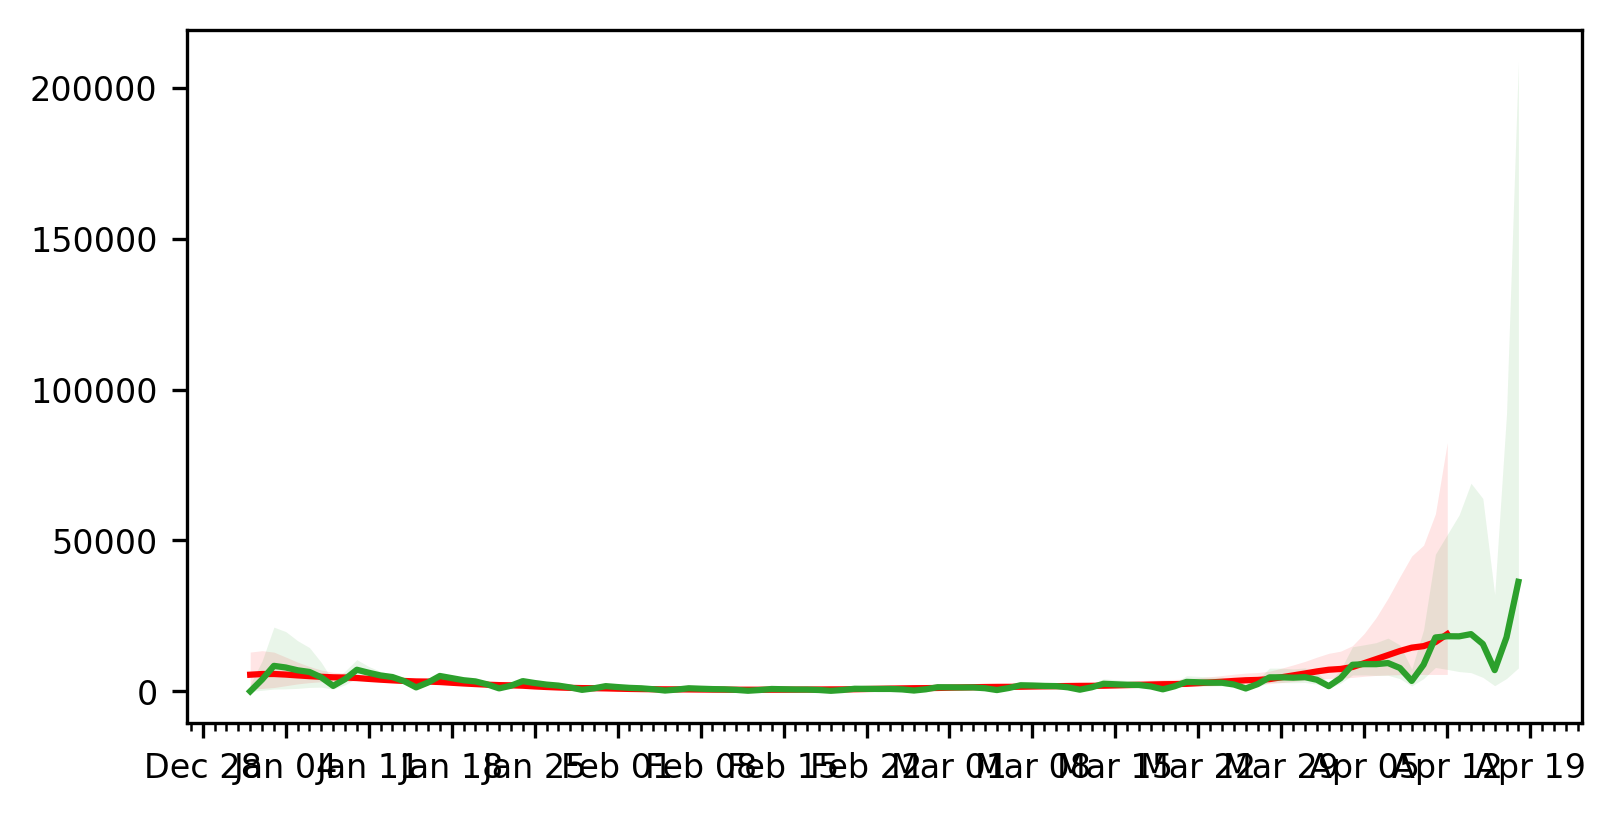

In [311]:
ax = cov19.plot._timeseries(x=np.arange(0,102),y=new_cases_smooth,what="model",color="red")
cov19.plot._timeseries(x=np.arange(0,108),y=new_cases,what="model",ax=ax)
#ax.plot(t,I,color="red")
plt.show()


In [318]:
def RungeKutta4(dt, f, t, y_t ):
    """
        Performs runge kutta 4 on a function with parameters
        Parameters
        ----------
        dt : number
            size of the timestep
        f : function
            function on which the runge kutta steps should be performed
        t : number
            time
        y : array
            state vector at time t
    """
    k_1 = f(t, y_t)
    k_2 = f(t + dt / 2, y_t + k_1 * dt / 2)
    k_3 = f(t + dt / 2, y_t + k_2 * dt / 2)
    k_4 = f(t + dt, y_t + k_3 * dt)
    return y_t + dt / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

def SIR(lambda_t, y0, t_max=100, mu=0.11, inf_S_pool=True):
    """
        Calculates a SIR model by computing the next timesteps via. Runge Kutta 4. 
        Adds a time dependent lambda array to the SIR model.
        Parameters
        ----------
        lambda_t : array
            Should be generated by one of the model lambda functions for the right size
        y0 : array
            Initial state vector containing S0,I0,R0
        Return
        ------
        t , S, I, R
    """
    # SIR model as vector
    def f(t, y_t):
        """
        The function for the SIR model
        Parameters
        ----------
        t: number
            current timestep
        y: array
            SIR state vector [S,I,R,lambda]
        """
        S = y_t[0]
        I = y_t[1]
        R = y_t[2]
        λ = y_t[3]
        SIR_next = λ * np.array([-1.0, 1.0, 0.0]) * S * I / N + np.array(
            [0, -mu * I, mu * I]
        )
        if inf_S_pool:
            SIR_next[0] = S_0
        return np.append(SIR_next, 0)

    # ------------------------------------------------------------------------------ #
    # Preliminar parameters
    # ------------------------------------------------------------------------------ #
    λ_t = lambda_t

    S_0 = y0[0]
    I_0 = y0[1]
    R_0 = y0[2]

    N = S_0 + I_0 + R_0

    t = np.arange(start=0, stop=t_max, step=1)
    # Array for state vectors, already filled for the time 0
    y_t = [np.array([S_0, I_0, R_0, λ_t[0]])]
    # ------------------------------------------------------------------------------ #
    # Timesteps
    # ------------------------------------------------------------------------------ #
    for i in range(len(t) - 1):  # -1 because we append to an array
        """
        RungeKutta4 returns state vector but the last entry (lambda) has to be 
        discarded
        """
        y_t.append(RungeKutta4(0.5, f, t[i], y_t[i]))
        y_t[i + 1][3] = λ_t[i + 1]
        
    y_t = np.array(y_t)
    return t, y_t[:, 0], y_t[:, 1], y_t[:, 2]

Run different models based on R_base
- as reference:https://www.nature.com/articles/s41467-021-26013-4

In [337]:
def model_run(R_add, error, tmax=100, mu=0.11):
    """ Computes SEIR model run
    
        Parameters
        ----------
        R_add : number
            R_add value
        error : array numbers
            Additive error on R_add i.e +-
    """
    
    # Calculate lambda value from R
    lambda_mean = (np.mean(R_base,axis=(0)) + R_add )** (1/4) - 1  + mu
    lambda_upper = (np.mean(R_base,axis=(0)) + R_add + error[0] )** (1/4) - 1  + mu
    lambda_lower = (np.mean(R_base,axis=(0)) + R_add - error[1] )** (1/4) - 1  + mu
    
    lambda_t = np.ones(tmax*2)
    t, S, I, R = SIR(lambda_mean, [83129285,np.mean(new_cases_smooth,axis=0)[0],0],t_max=tmax, mu=mu, inf_S_pool=False)
    _, _, upper, _, = SIR(lambda_upper, [83129285,np.mean(new_cases_smooth,axis=0)[0],0], mu=mu, t_max=tmax, inf_S_pool=False)
    _, _, lower, _, = SIR(lambda_lower, [83129285,np.mean(new_cases_smooth,axis=0)[0],0], mu=mu, t_max=tmax, inf_S_pool=False)
    return t, I, [lower, upper]


models = {}
mu = 0.11

models["base"] = {}
R_add = 0
R_error = [0,0]
t, models["base"]["I"], models["base"]["error"] = model_run(R_add,R_error)
models["base"]["R_add"] = R_add
models["base"]["R_error"] = R_error


models["soccer/low"] = {}
R_add = 0.1
R_error = [0.05,0.05]
t, models["soccer/low"]["I"], models["soccer/low"]["error"] = model_run(R_add,R_error)
models["soccer/low"]["R_add"] = R_add
models["soccer/low"]["R_error"] = R_error


models["medium"] = {}
R_add = 0.2
R_error = [0.05,0.05]
t, models["medium"]["I"], models["medium"]["error"] = model_run(R_add,R_error)
models["medium"]["R_add"] = R_add
models["medium"]["R_error"] = R_error

models["high"] = {}
R_add = 0.3
R_error = [0.05,0.05]
t, models["high"]["I"], models["high"]["error"] = model_run(R_add,R_error)
models["high"]["R_add"] = R_add
models["high"]["R_error"] = R_error

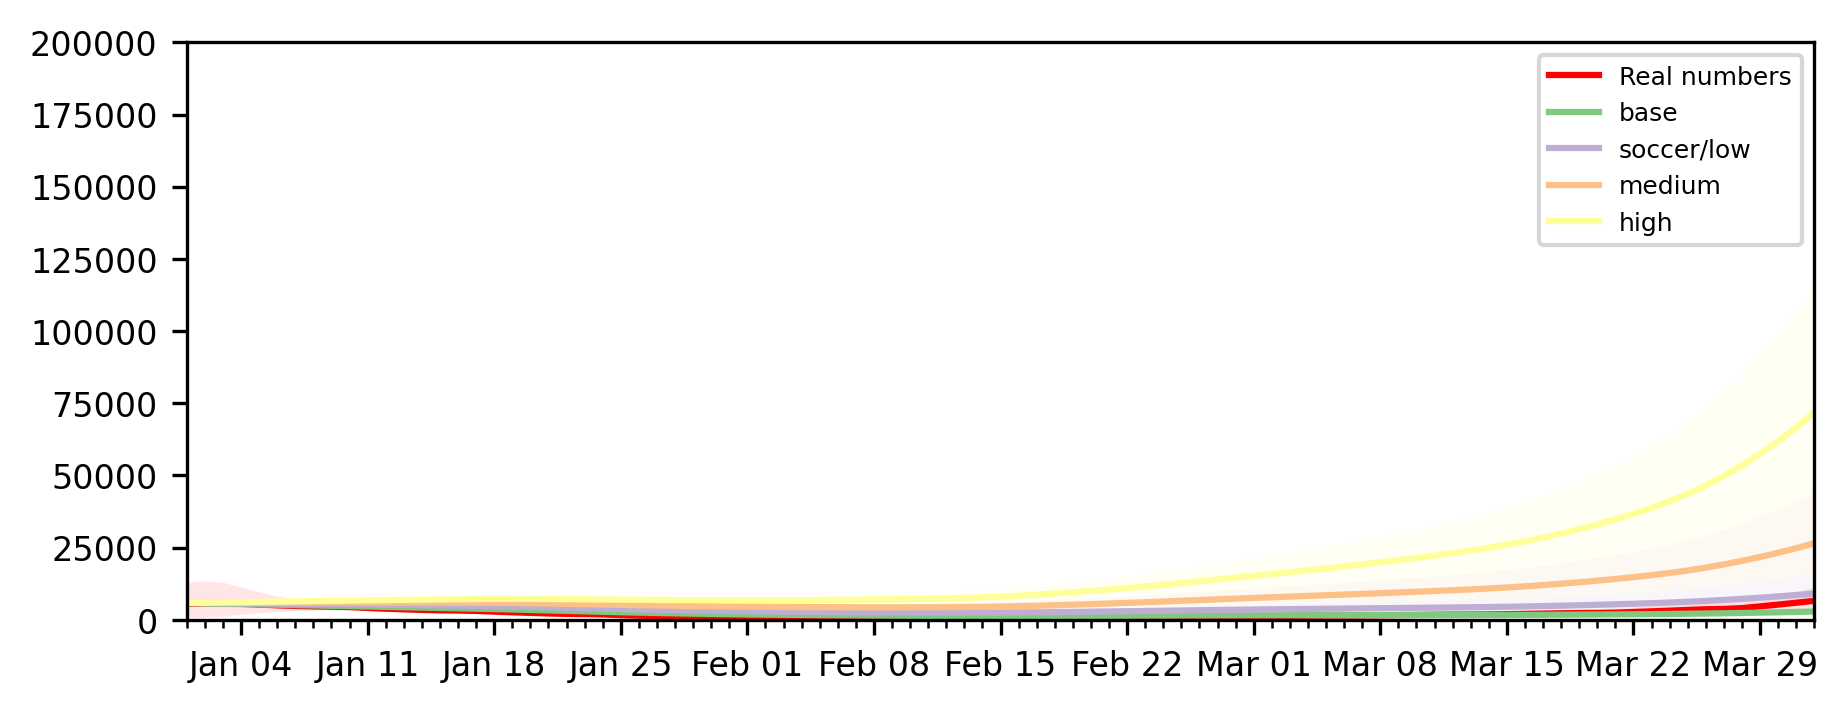

In [338]:
fig, ax= plt.subplots(1,1,figsize=(7,2.5))
cov19.plot._timeseries(x=np.arange(0,102),y=new_cases_smooth,what="model",color="red",ax=ax,label="Real numbers")
cmap = plt.get_cmap("Accent")
for i,model in enumerate(models):
    ax.plot(t,models[model]["I"],label=model,color=cmap(i))
    ax.fill_between(t,models[model]["error"][0],models[model]["error"][1],color=cmap(i),alpha=0.1,edgecolor=None)


ax.set_ylim(0,200000)
ax.set_xlim(0,90)
plt.legend()
plt.show()

## Plotting

In [339]:
from covid19_soccer.plot.utils import lighten_color
from matplotlib.colors import to_hex
def effect_mean(ax, labels, y, y_err, colors):
    
    # Plot vertical lines without connection
    lines = ax.vlines(
        x=labels,
        ymin=y-y_err[:,0],
        ymax=y+y_err[:,1],
        lw=3,
        colors=colors
    )
    
    lines.set_capstyle("round")
    # Plot horizontal lines at mean
    ax.scatter(
        x=labels,
        y=y,
        marker="o",
        s=20,
        zorder=10,
        c="white",
        edgecolor=colors,
    )
    
    # Markup
    ax.set_ylabel("$\sum \Delta R$")
    ax.set_xlim(-0.25,len(y)-0.75)
    ax.set_ylim(min(y)-y_err.max(),max(y)+y_err.max())
    #ax.set_xticklabels(labels,rotation=45,ha='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    return ax

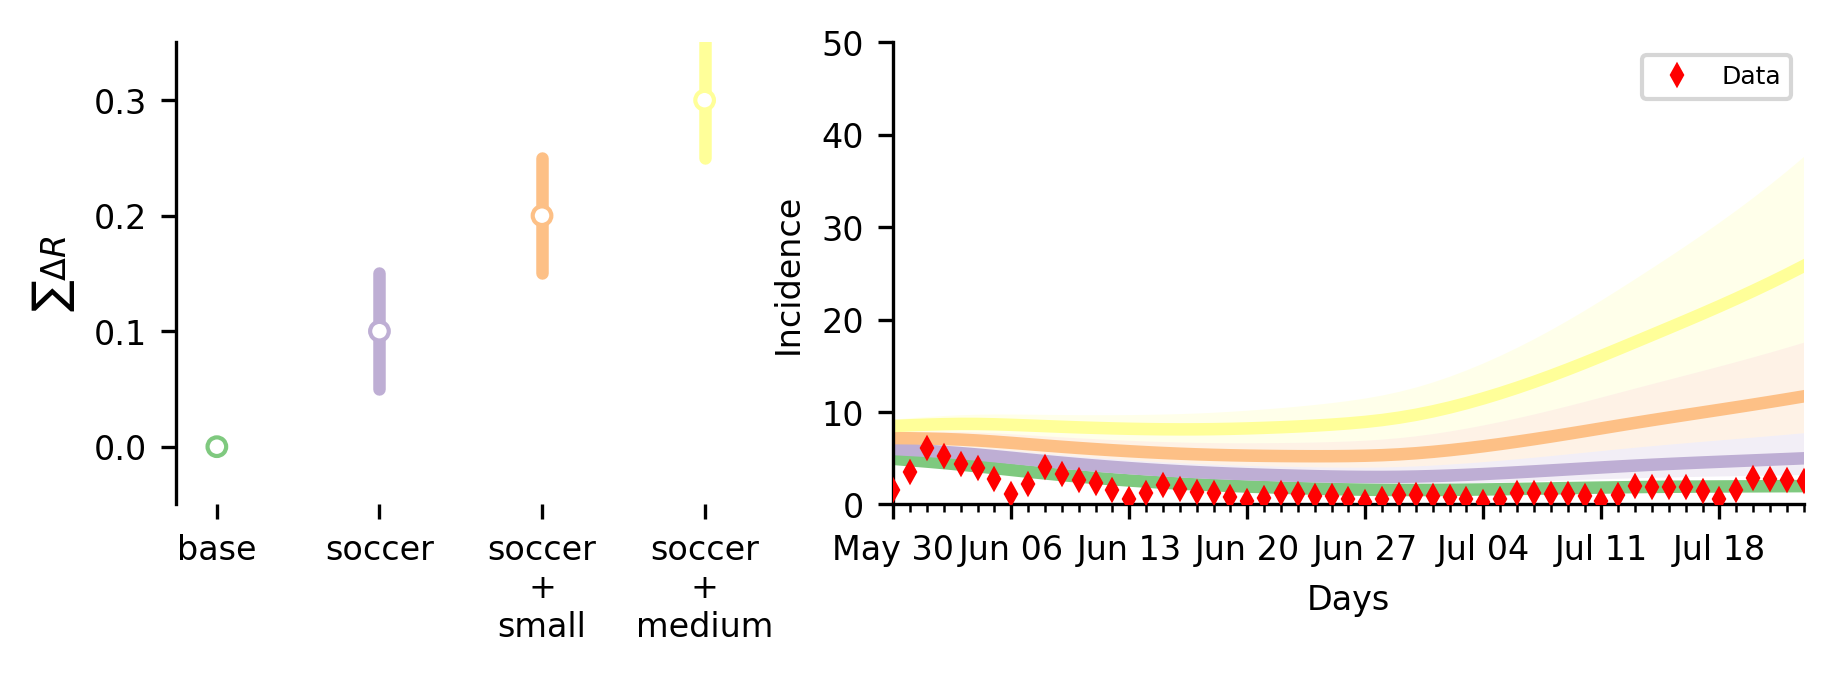

In [391]:
fig, axes = plt.subplots(1,2,figsize=(7,2.0),gridspec_kw={"width_ratios":[0.5,0.8,]})

# Colors
cmap = plt.get_cmap("Accent")
colors = [to_hex(cmap(i),keep_alpha=True) for i in range(len(models))]

# Plotting change in R
labels = ["base","soccer","soccer\n+\nsmall","soccer\n+\nmedium"]

add_R = [models[model]["R_add"] for model in models]
add_R_error = np.array([models[model]["R_error"] for model in models])
lines = effect_mean(axes[0],labels,add_R,add_R_error,colors)

# Plot real data
cov19.plot._timeseries(
    x=pd.date_range(pm_model.sim_begin,pm_model.sim_end),
    y=np.mean(np.sum(trace.posterior["new_cases"],axis=-1),axis=(0,1))/83129285*100000,
    what="data",
    ax=axes[1],
    color="red",
    label="Data",
    ms=3,
    zorder=3)

# Model plots i.e. new cases
for i,model in enumerate(models):
    covid19_soccer.plot.timeseries._timeseries(
        ax=axes[1],
        x=pd.date_range(pm_model.sim_begin,pm_model.sim_begin+datetime.timedelta(days=len(t)-1)),
        y=models[model]["I"]/83129285*100000,
        color=colors[i],
        what="model",
        date_format=False,
        lw=3
    )
    axes[1].fill_between(pd.date_range(pm_model.sim_begin,pm_model.sim_begin+datetime.timedelta(days=len(t)-1)),models[model]["error"][0]/83129285*100000,models[model]["error"][1]/83129285*100000,color=colors[i],alpha=0.2,edgecolor=None)

# Markup
axes[1].legend()
axes[1].set_xlim(datetime.datetime(2021,5,30),datetime.datetime(2021,7,23))
axes[1].set_ylim(0,50)
axes[1].set_xlabel("Days")
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_ylabel("Incidence")
fig.savefig(f"{fig_path}/what_if.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/what_if.png", **save_kwargs)
plt.show()

(108,)